# Cluster analysis

In [1]:
import signal_ana as ana
import pandas as pd
%load_ext autoreload
%autoreload 2

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Load the signals
df = ana.load_signals('/eos/user/l/llayer/features_30.h5')
# Exclude the eruption days
eruption_days = [ ('2019-07-03', '2019-07-04'), ('2019-08-28', '2019-08-29'), ('2019-08-29', '2019-08-30')]
df = ana.exclude_days(df, eruption_days)
features_wf = ana.get_features(df, 'waveform')
features_lpc = ana.get_features(df, 'lpc_coeff')
features_amp = ana.get_features(df, 'amplitude')

In [11]:
len(features_wf)

19748

In [3]:
from scipy.stats import kde
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_tsne(x, y):

    cmap=plt.get_cmap('magma')

    k = kde.gaussian_kde([x,y])
    bins_y = 500
    bins_x = 500
    xi, yi = np.mgrid[x.min():x.max():bins_x*1j, y.min():y.max():bins_y*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Make the plot
    fig, ax = plt.subplots(figsize=(8,8))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cmap)
    plt.ylabel('t-SNE x2', fontsize=15)
    plt.xlabel('t-SNE x1', fontsize=15)
    
    plt.show()

In [4]:
def plot_tsne_scatter(x, y):

    # Make the plot
    fig, ax = plt.subplots(figsize=(8,8))
    plt.scatter(x,y, marker='.', s=30, lw=0, alpha=0.7)
    plt.ylabel('t-SNE x2', fontsize=15)
    plt.xlabel('t-SNE x1', fontsize=15)
    
    plt.show()

In [5]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

def silhouette_cls(X, max_cls = 8):

    range_n_clusters = range(2, max_cls+1)
    silhouette_scores = []
    for n_clusters in range_n_clusters:

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_scores.append( silhouette_score(X, cluster_labels) )
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_scores[-1])
        
    fig = plt.figure(figsize=(6,4), dpi=80)
    plt.scatter(range_n_clusters, silhouette_scores)
    plt.ylabel('Silhouette score', fontsize=15)
    plt.xlabel('Clusters', fontsize=15)
    plt.show()
    
    return silhouette_scores

In [6]:
def plot_silhouette(X, tsne_x, tsne_y, n_clusters):

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette score",  fontsize=15)
    ax1.set_ylabel("Cluster", fontsize=15)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsne_x, tsne_y, marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    #ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("t-SNE x1",  fontsize=15)
    ax2.set_ylabel("t-SNE x2",  fontsize=15)

    #plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
    #              "with n_clusters = %d" % n_clusters),
    #             fontsize=14, fontweight='bold')

    plt.show()

In [7]:
import numpy as np
from matplotlib import cm
from datetime import datetime, date
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec


def cluster_time(df, col, n_clusters, timebins=200, plot_hist = True):

    df['time_int'] = df.time.astype(np.int64)
    x, y = df['time_int'], df[col]

    
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=(timebins, n_clusters))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]+1]
    err1, err2 = ana.get_erruption_time()

    fig = plt.figure(figsize=(8, 6), dpi=100)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08) 
    ax0 = plt.subplot(gs[0])
    
    cluster_bins = []
    for i in range(n_clusters):
    # the histogram of the data
        #fig = plt.figure(1, figsize=(8, 6))
        #ax = fig.add_subplot(111)
        cluster = df[df[col] == i]
        n, bins, patches = ax0.hist(cluster['time_int'], timebins, alpha=0.75, label = 'Cluster ' + str(i))
        cluster_bins.append(n)
        
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax0.set_xlim(1.56009035e+18, 1.56838442e+18)
    ax0.axvline(x=err1, color='r', linestyle='dashed', linewidth=2, label = 'Paroxism')
    ax0.axvline(x=err2, color='r', linestyle='dashed', linewidth=2)
    ax0.set_xticklabels([]) 
    ax0.set_ylabel("Counts",  fontsize=15)
    plt.legend(loc = 'upper left')
    
    #plt.show()
    ax1 = plt.subplot(gs[1])
    if n_clusters == 2:
        
        #fig = plt.figure(1, figsize=(8, 6))
        #ax = fig.add_subplot(111)
        center = (bins[:-1] + bins[1:]) / 2
        ratio = [ (float(cls1) / float(cls2)) for cls1, cls2 in zip(cluster_bins[0], cluster_bins[1])]
        print(ratio)
        ax1.plot(center, ratio, linewidth=2)
        start, end = 1.56009035e+18, 1.56838442e+18
        ax1.set_xlim(start, end)
        ax1.axvline(x=err1, color='r', linestyle='dashed', linewidth=2)
        ax1.axvline(x=err2, color='r', linestyle='dashed', linewidth=2)
        ax1.axhline(1, color='k', linestyle='dashed', linewidth=1)
        #ax1.xaxis.set_ticks(np.arange(start, end, (end - start / 10)))
        ax1.set_xticklabels([datetime.fromtimestamp(ts / 1e9).strftime('%D') for ts in ax1.get_xticks()])
        ax1.set_ylabel("Ratio",  fontsize=15)
        ax1.set_yscale('log')
        #ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
        ax1.set_ylim([0.1,10])
        plt.xticks(rotation=45)
    plt.show()
    
    return center, ratio
    


In [8]:
def plot_centers(centers):
    
    fig = plt.figure(figsize=(6,4), dpi=80)
    for i in range(len(centers)):
        plt.plot(centers[i], linewidth = 2, label = 'Cluster ' + str(i))
    plt.ylabel("Counts [a.u.]",  fontsize=15)
    plt.legend(loc='upper right', prop={'size': 12})

## 1. Filtered signal

### Raw clustering

In [9]:
wf = pd.read_hdf('data/tsne_wf.h5', 'frame')

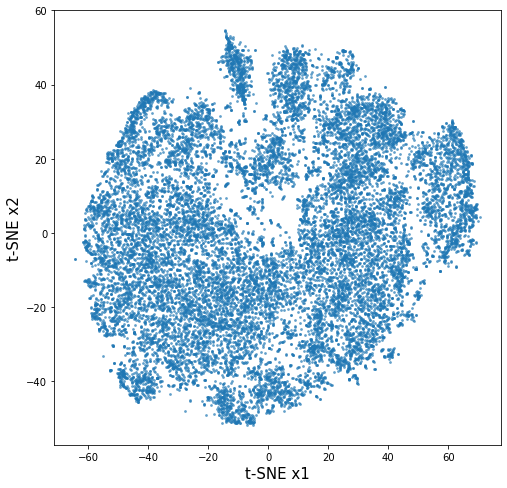

In [10]:
plot_tsne_scatter(wf['tsne_x'], wf['tsne_y'])

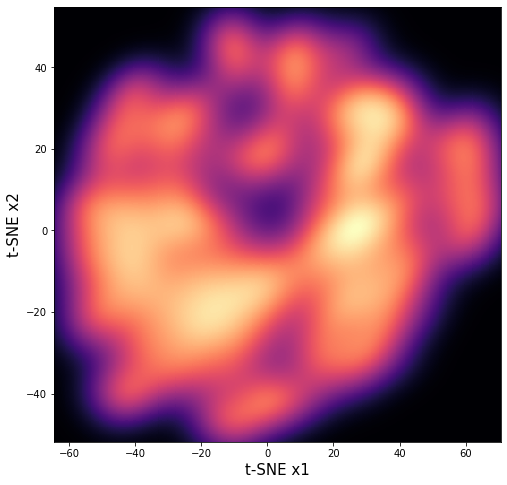

In [30]:
plot_tsne(wf['tsne_x'], wf['tsne_y'])

Text(0.5, 0, 'Clusters')

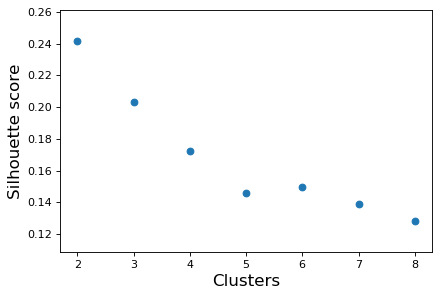

In [47]:
silhouette_cls(features_wf, max_cls = 8)

For n_clusters = 2 The average silhouette_score is : 0.241790574487


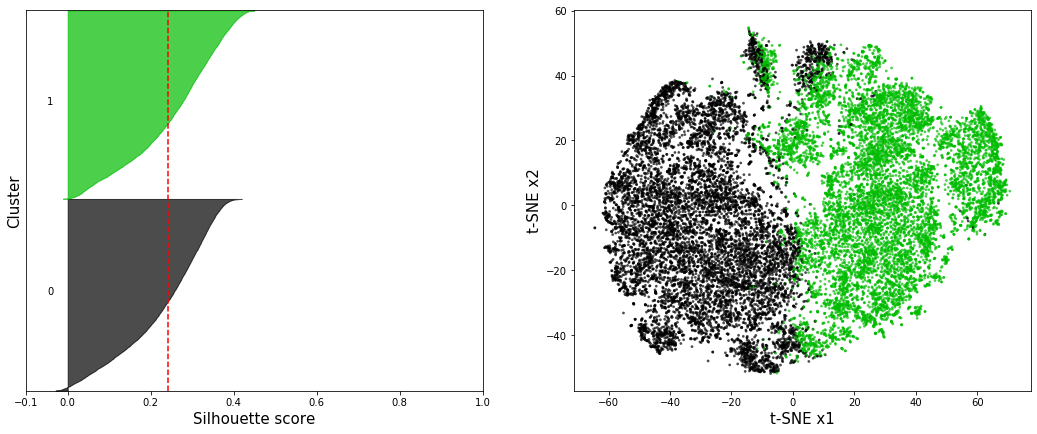

In [16]:
plot_silhouette(features_wf, wf['tsne_x'], wf['tsne_y'], 2)

For n_clusters = 3 The average silhouette_score is : 0.203352483904


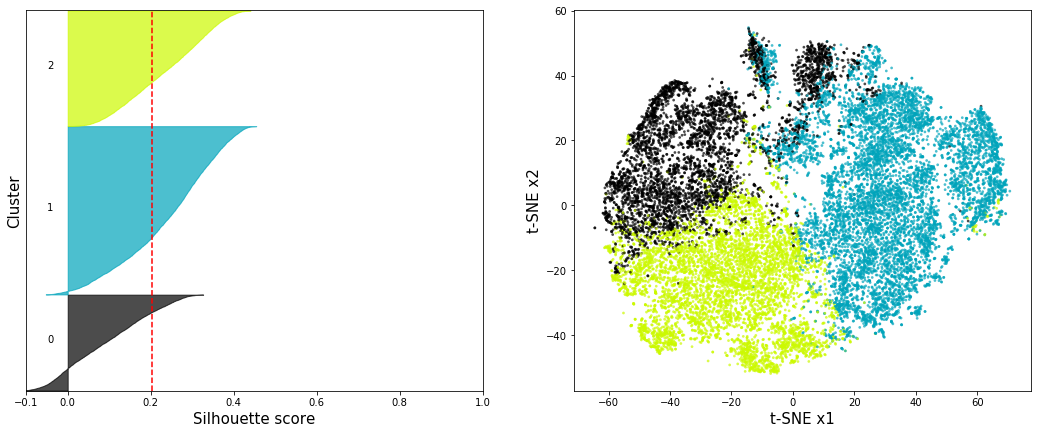

In [10]:
plot_silhouette(features_wf, wf['tsne_x'], wf['tsne_y'], 3)

For n_clusters = 4 The average silhouette_score is : 0.172576035453


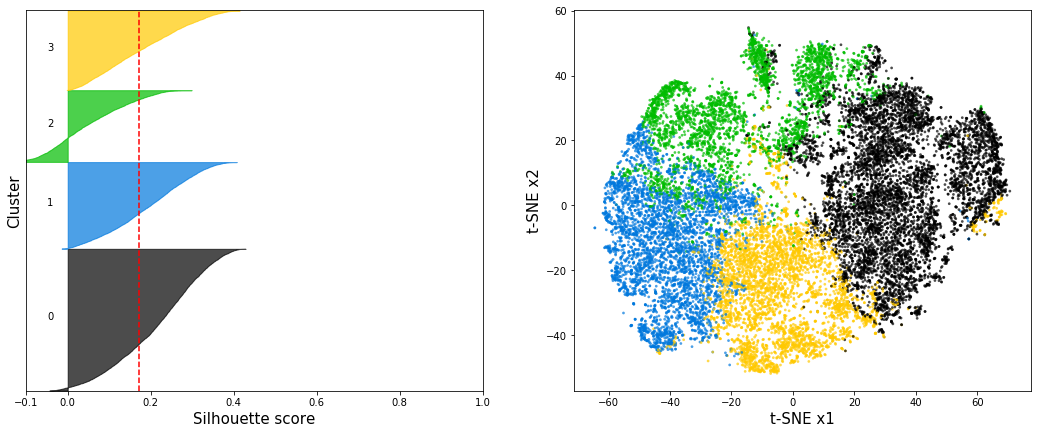

In [17]:
plot_silhouette(features_wf, wf['tsne_x'], wf['tsne_y'], 4)

In [10]:
# Best number of clusters
n_cluster = 2
wf['kmeans'], centers = ana.run_kmeans(features_wf, n_cluster)

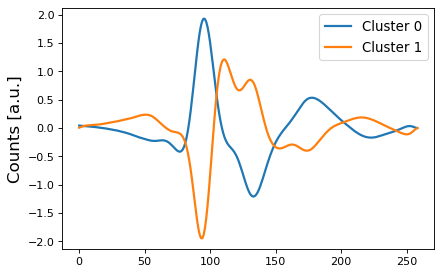

In [11]:
plot_centers(centers)

[1.430232558139535, 0.5034013605442177, 1.711340206185567, 2.926829268292683, 4.0, 4.888888888888889, 0.6216216216216216, 0.8228346456692913, 1.6631578947368422, 1.4210526315789473, 2.8358208955223883, 4.7375, 6.450704225352113, 5.022988505747127, 4.063157894736842, 4.362745098039215, 5.277777777777778, 1.1814814814814816, 1.572072072072072, 0.9807692307692307, 0.512396694214876, 0.75, 0.6666666666666666, 0.34710743801652894, 0.2159090909090909, 0.23076923076923078, 0.36046511627906974, 0.2724358974358974, 0.5856777493606138, 0.3383333333333333, 0.25316455696202533, 0.16323024054982818, 0.28690807799442897, 0.26176470588235295, 0.38799076212471134, 0.2967032967032967, 0.6007067137809188, 0.75, 0.8773006134969326, 0.3617886178861789, 0.8, 1.5, 2.1052631578947367, 1.2924528301886793, 2.2795698924731185, 1.6551724137931034, 2.3666666666666667, 2.01980198019802, 1.2837837837837838, 1.1756756756756757]


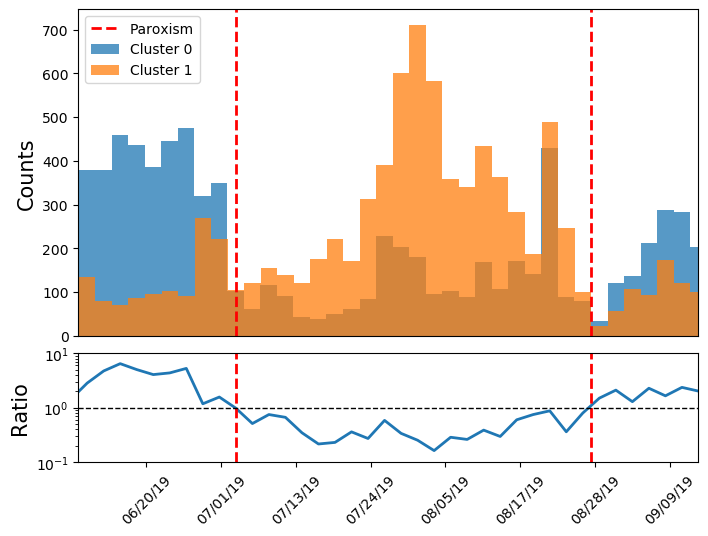

In [26]:
ratio_wf = cluster_time(wf, 'kmeans', 2, timebins=50)

In [30]:
pd.DataFrame(ratio_wf).to_hdf('data/ratio_wf.h5', 'frame')

## 2. Filtered signal + LPC + Amplitude

In [44]:
full = pd.read_hdf('data/tsne_full.h5', 'frame')

In [45]:
features_full = np.concatenate((features_wf, features_lpc, features_amp),axis=1)

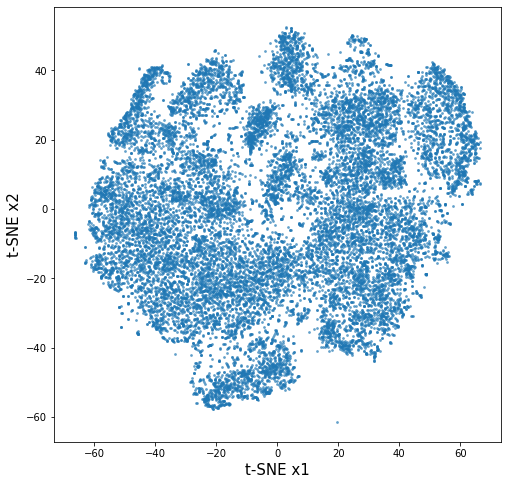

In [46]:
plot_tsne_scatter(full['tsne_x'], full['tsne_y'])

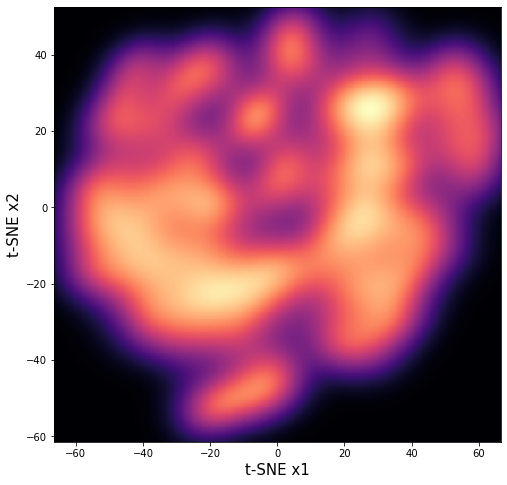

In [51]:
plot_tsne(full['tsne_x'], full['tsne_y'])

For n_clusters = 2 The average silhouette_score is : 0.219210244028
For n_clusters = 3 The average silhouette_score is : 0.182252226825
For n_clusters = 4 The average silhouette_score is : 0.152712255672
For n_clusters = 5 The average silhouette_score is : 0.126373404071
For n_clusters = 6 The average silhouette_score is : 0.12879431851
For n_clusters = 7 The average silhouette_score is : 0.119329893188
For n_clusters = 8 The average silhouette_score is : 0.112982508263


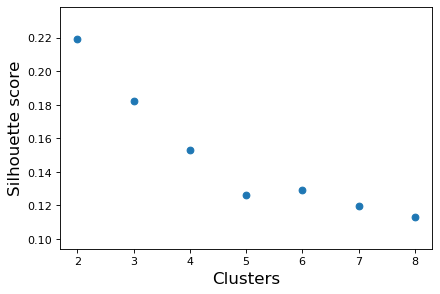

In [173]:
silhouette_cls(features_full, max_cls = 8)

For n_clusters = 2 The average silhouette_score is : 0.219210244028


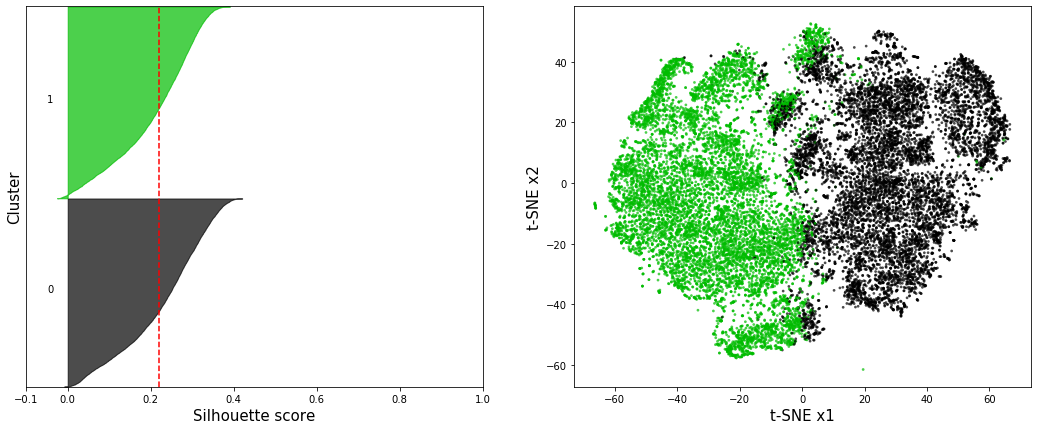

In [174]:
plot_silhouette(features_full, full['tsne_x'], full['tsne_y'], 2)

In [48]:
# Best number of clusters
n_cluster = 2
full['kmeans'], centers = ana.run_kmeans(features_full, n_cluster)

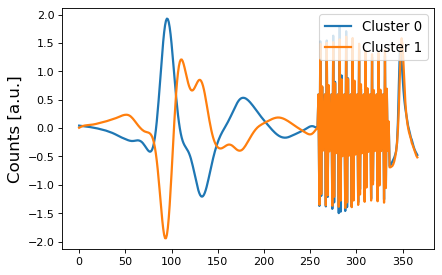

In [34]:
plot_centers(centers)

[1.430232558139535, 0.5034013605442177, 1.711340206185567, 2.926829268292683, 4.0, 4.888888888888889, 0.6216216216216216, 0.8228346456692913, 1.640625, 1.4, 2.857142857142857, 4.7375, 6.450704225352113, 4.954545454545454, 4.010416666666667, 4.362745098039215, 5.277777777777778, 1.1814814814814816, 1.572072072072072, 0.9807692307692307, 0.512396694214876, 0.75, 0.6666666666666666, 0.3360655737704918, 0.2159090909090909, 0.23076923076923078, 0.3684210526315789, 0.268370607028754, 0.5816326530612245, 0.3383333333333333, 0.25140449438202245, 0.15726495726495726, 0.27624309392265195, 0.26176470588235295, 0.38799076212471134, 0.2967032967032967, 0.6007067137809188, 0.75, 0.9205020920502092, 0.3617886178861789, 0.8, 1.5, 2.1052631578947367, 1.2924528301886793, 2.24468085106383, 1.64, 2.4237288135593222, 1.9611650485436893, 1.2684563758389262, 1.1756756756756757]


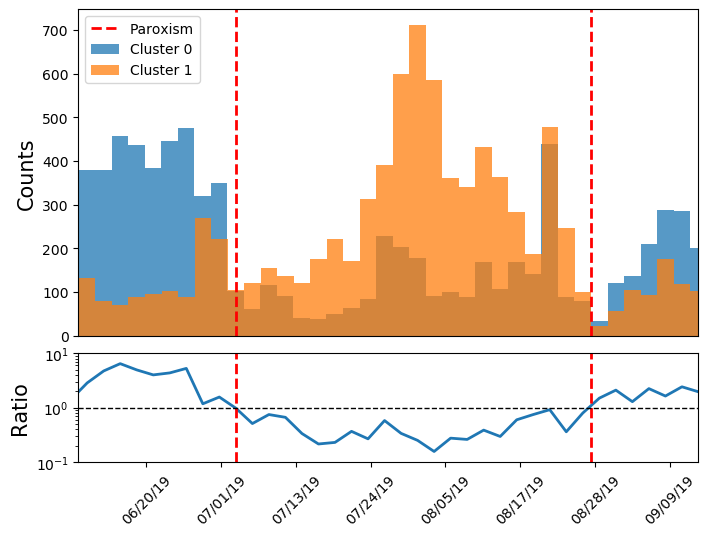

In [49]:
center, ratio_full = cluster_time(full, 'kmeans', 2, timebins=50)

In [50]:
pd.DataFrame(ratio_full).to_hdf('data/ratio_full.h5', 'frame')
pd.DataFrame(center).to_hdf('data/center.h5', 'frame')

## Dense autoencoder

In [8]:
def plot_dense(dim):
    dense = pd.read_hdf('data/tsne_dense' + str(dim) + '.h5', 'frame')
    features = dense.drop(['time', 'tsne_x', 'tsne_y'], axis=1).values
    plot_tsne(dense['tsne_x'], dense['tsne_y'])
    scores = silhouette_cls(features, max_cls = 8)
    return scores

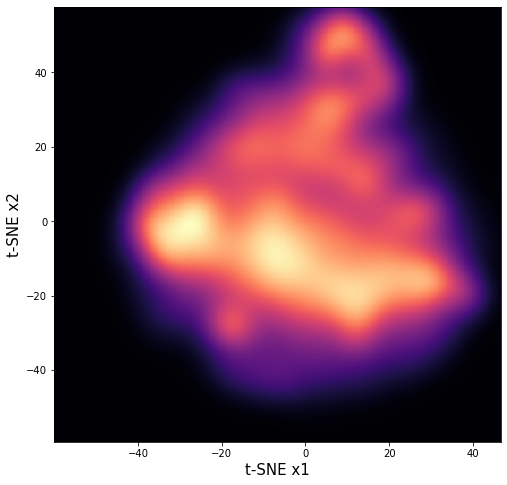

For n_clusters = 2 The average silhouette_score is : 0.0819502
For n_clusters = 3 The average silhouette_score is : 0.0462041
For n_clusters = 4 The average silhouette_score is : 0.0455768
For n_clusters = 5 The average silhouette_score is : 0.0448324
For n_clusters = 6 The average silhouette_score is : 0.0385019
For n_clusters = 7 The average silhouette_score is : 0.0321759
For n_clusters = 8 The average silhouette_score is : 0.0278656


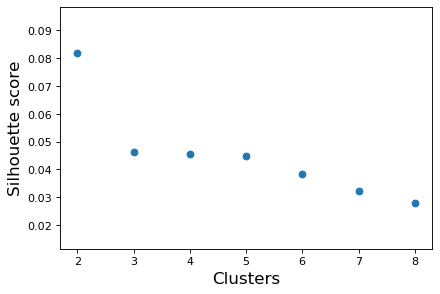

In [9]:
score_dense100 = plot_dense(100)

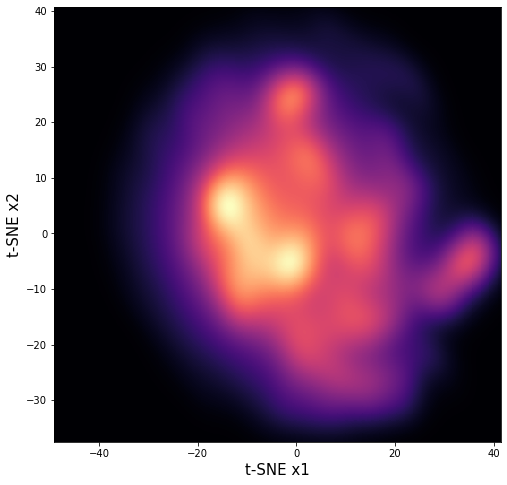

For n_clusters = 2 The average silhouette_score is : 0.0296998
For n_clusters = 3 The average silhouette_score is : 0.0136318
For n_clusters = 4 The average silhouette_score is : 0.00866982
For n_clusters = 5 The average silhouette_score is : 0.0092981
For n_clusters = 6 The average silhouette_score is : 0.00828072
For n_clusters = 7 The average silhouette_score is : 0.00688675
For n_clusters = 8 The average silhouette_score is : 0.00654196


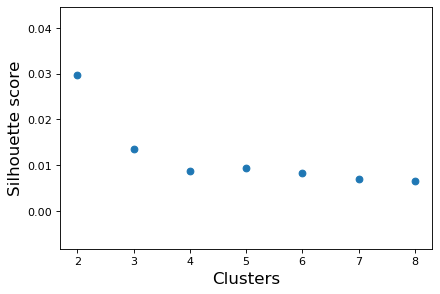

In [10]:
score_dense200 = plot_dense(200)

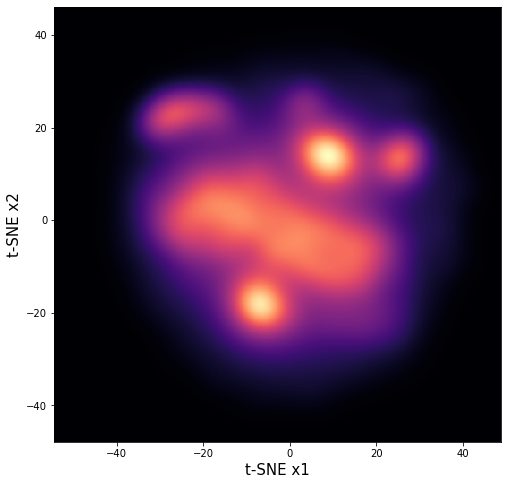

For n_clusters = 2 The average silhouette_score is : 0.0174767
For n_clusters = 3 The average silhouette_score is : 0.00854368
For n_clusters = 4 The average silhouette_score is : 0.00908348
For n_clusters = 5 The average silhouette_score is : 0.00763735
For n_clusters = 6 The average silhouette_score is : 0.00266963
For n_clusters = 7 The average silhouette_score is : 0.00211397
For n_clusters = 8 The average silhouette_score is : 0.00111371


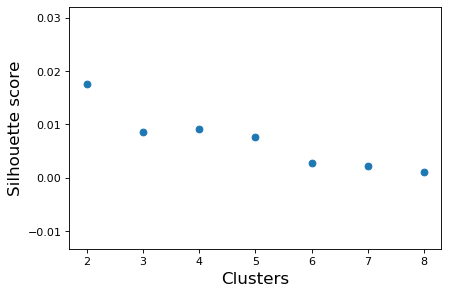

In [11]:
score_dense300 = plot_dense(300)

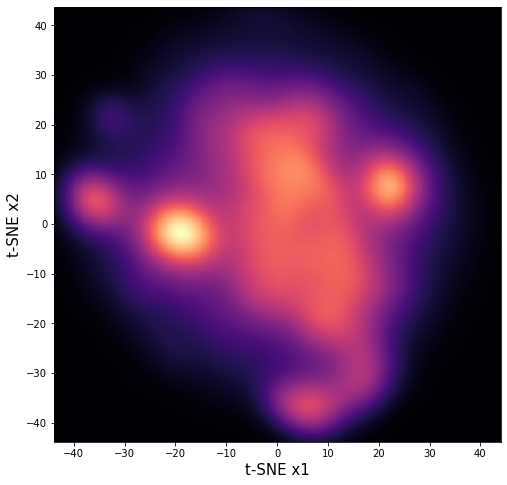

For n_clusters = 2 The average silhouette_score is : 0.0279071
For n_clusters = 3 The average silhouette_score is : 0.0191123
For n_clusters = 4 The average silhouette_score is : 0.009057
For n_clusters = 5 The average silhouette_score is : 0.00994013
For n_clusters = 6 The average silhouette_score is : 0.00978945
For n_clusters = 7 The average silhouette_score is : 0.00220966
For n_clusters = 8 The average silhouette_score is : 0.00314135


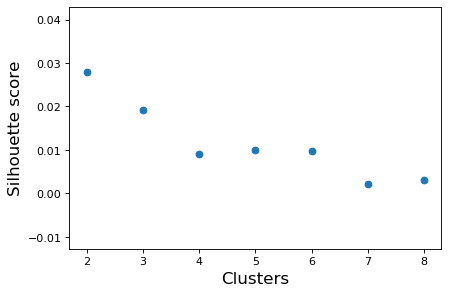

In [12]:
score_dense400 = plot_dense(400)

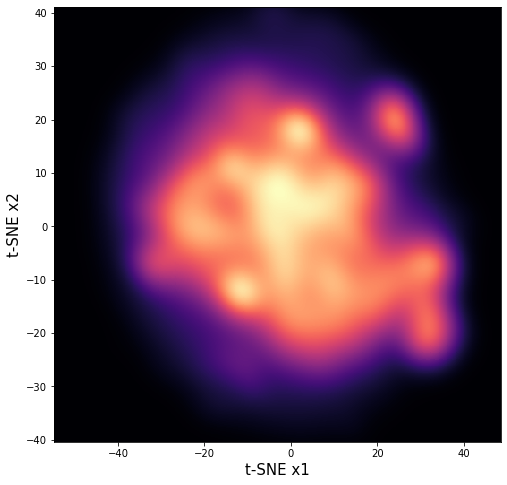

For n_clusters = 2 The average silhouette_score is : 0.0557217
For n_clusters = 3 The average silhouette_score is : 0.0317993
For n_clusters = 4 The average silhouette_score is : 0.0199668
For n_clusters = 5 The average silhouette_score is : 0.0163127
For n_clusters = 6 The average silhouette_score is : 0.0158903
For n_clusters = 7 The average silhouette_score is : 0.0130783
For n_clusters = 8 The average silhouette_score is : 0.0117573


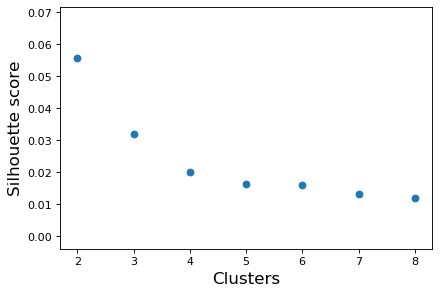

In [13]:
score_dense500 = plot_dense(500)

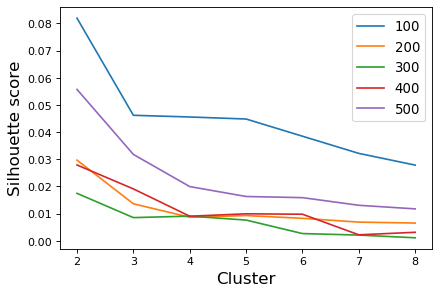

In [15]:
cls_range = range(2,9)

plt.figure(figsize=(6,4), dpi=80)
plt.plot(cls_range, score_dense100)
plt.plot(cls_range, score_dense200)
plt.plot(cls_range, score_dense300)
plt.plot(cls_range, score_dense400)
plt.plot(cls_range, score_dense500)
plt.ylabel('Silhouette score', fontsize=15)
plt.xlabel('Cluster', fontsize=15)
plt.legend(['100', '200', '300', '400', '500'], loc='upper right', prop={'size': 12})

## LSTM autoencoder

In [19]:
def plot_lstm(dim):
    lstm = pd.read_hdf('data/tsne_lstm' + str(dim) + '.h5', 'frame')
    features = lstm.drop(['time', 'tsne_x', 'tsne_y'], axis=1).values
    plot_tsne(lstm['tsne_x'], lstm['tsne_y'])
    scores = silhouette_cls(features, max_cls = 8)
    return scores

In [20]:
dims = [d * 31 for d in [8, 10, 12, 15]]

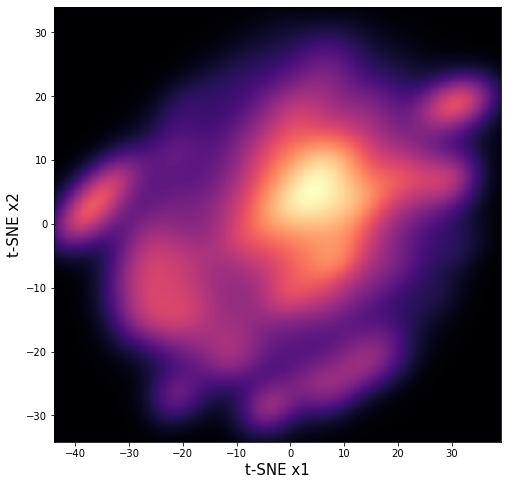

For n_clusters = 2 The average silhouette_score is : 0.0514662
For n_clusters = 3 The average silhouette_score is : 0.042973
For n_clusters = 4 The average silhouette_score is : 0.0389814
For n_clusters = 5 The average silhouette_score is : 0.0330563
For n_clusters = 6 The average silhouette_score is : 0.0309252
For n_clusters = 7 The average silhouette_score is : 0.0297798
For n_clusters = 8 The average silhouette_score is : 0.0288542


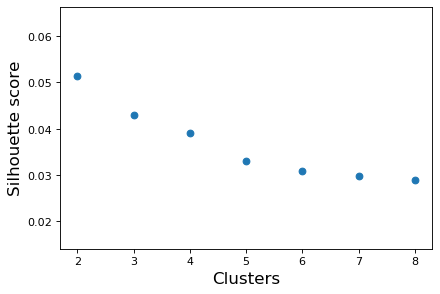

In [21]:
score_lstm8 = plot_lstm(dims[0])

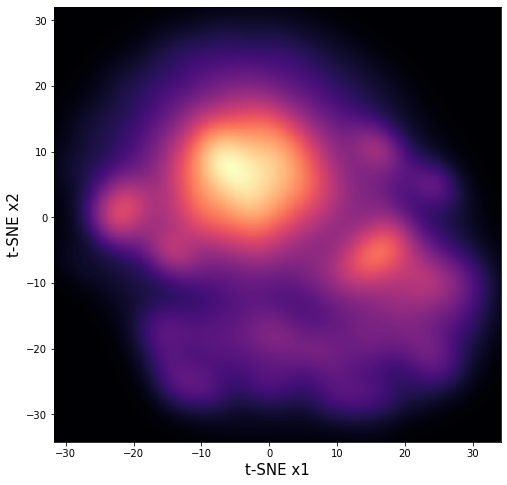

For n_clusters = 2 The average silhouette_score is : 0.0262742
For n_clusters = 3 The average silhouette_score is : 0.0228649
For n_clusters = 4 The average silhouette_score is : 0.0213797
For n_clusters = 5 The average silhouette_score is : 0.0191429
For n_clusters = 6 The average silhouette_score is : 0.018779
For n_clusters = 7 The average silhouette_score is : 0.0185829
For n_clusters = 8 The average silhouette_score is : 0.0153605


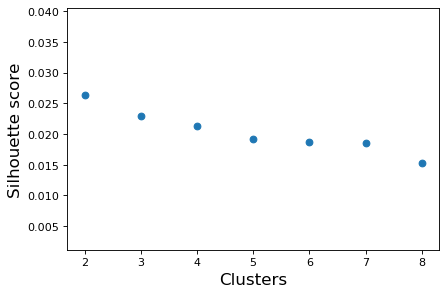

In [22]:
score_lstm10 = plot_lstm(dims[1])

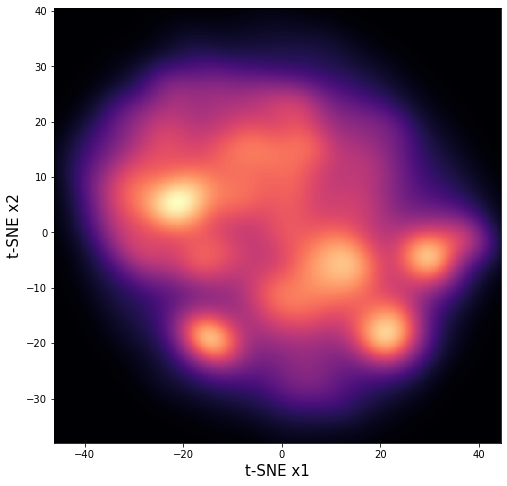

For n_clusters = 2 The average silhouette_score is : 0.0229858
For n_clusters = 3 The average silhouette_score is : 0.0192892
For n_clusters = 4 The average silhouette_score is : 0.0169478
For n_clusters = 5 The average silhouette_score is : 0.0161678
For n_clusters = 6 The average silhouette_score is : 0.0158272
For n_clusters = 7 The average silhouette_score is : 0.0142254
For n_clusters = 8 The average silhouette_score is : 0.0137004


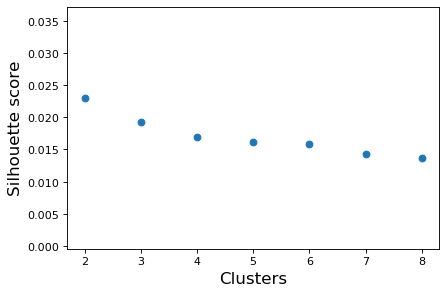

In [23]:
score_lstm12 = plot_lstm(dims[2])

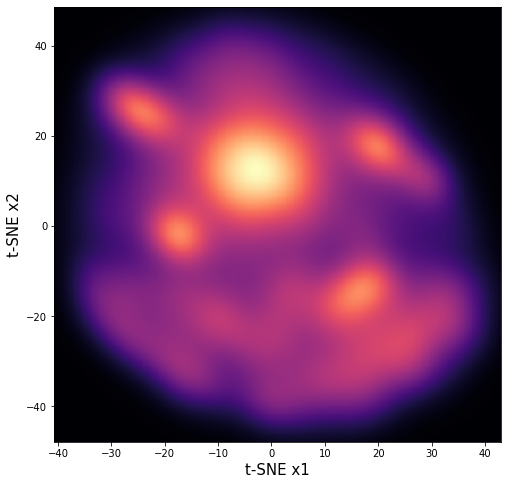

For n_clusters = 2 The average silhouette_score is : 0.0311013
For n_clusters = 3 The average silhouette_score is : 0.0256398
For n_clusters = 4 The average silhouette_score is : 0.0242693
For n_clusters = 5 The average silhouette_score is : 0.0235246
For n_clusters = 6 The average silhouette_score is : 0.0230876
For n_clusters = 7 The average silhouette_score is : 0.0220033
For n_clusters = 8 The average silhouette_score is : 0.0183655


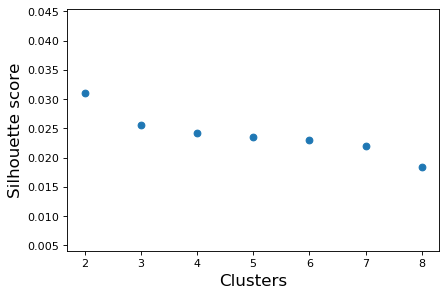

In [24]:
score_lstm15 = plot_lstm(dims[3])

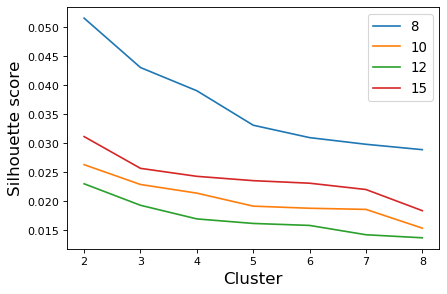

In [25]:
cls_range = range(2,9)
plt.figure(figsize=(6,4), dpi=80)
plt.plot(cls_range, score_lstm8)
plt.plot(cls_range, score_lstm10)
plt.plot(cls_range, score_lstm12)
plt.plot(cls_range, score_lstm15)
plt.ylabel('Silhouette score', fontsize=15)
plt.xlabel('Cluster', fontsize=15)
plt.legend(['8', '10', '12', '15'], loc='upper right', prop={'size': 12})